In [47]:
# auto reload modules for code updates

%load_ext autoreload 
%autoreload 2

# exclude standard libraries for autoreload evaluation

%aimport -pandas
%aimport -scipy.stats
%aimport -numpy
%aimport -matplotlib.pyplot


# import standard Python modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import scipy.stats as stats
import scipy.interpolate as interpolate
import pandas

import xlwings as xw # for interaction with Excel

# import custom modules

import default_calcs as default
import collateral_waterfall as cw
import prepayment_calcs as pc
import bond_pricing as bp
from utils import *

# set table output to 2 decimal places

pd.options.display.float_format = '{:,.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example of standard CPR curve

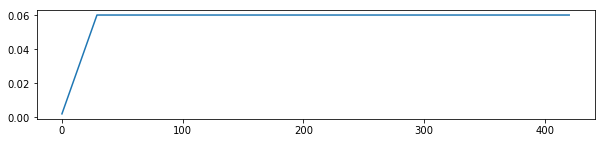

In [13]:
a=pc.cpr_curve_creator()
fig, ax = plt.subplots(figsize=(10,2))
plt.plot(a)
plt.show()

### Example of evaluating multiple PSA speeds

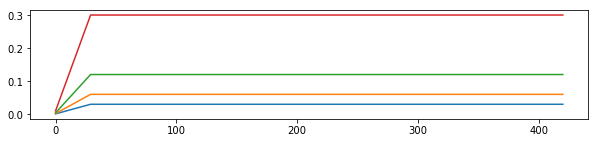

In [14]:
speeds = [.5,1,2,5]
curves = [pc.cpr_curve_creator()*np.array(speed) for speed in speeds]
handles = []

fig, ax = plt.subplots(figsize=(10,2))
for i, curve in enumerate(curves):
    ax.plot(curve)

plt.show()

### Example of creating vector of ending balances

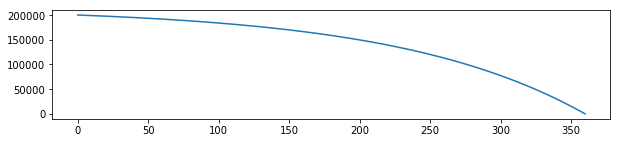

In [15]:
sched = cw.schedule_of_ending_balances(0.09, 360, 200000)['scheduled_balance']
a=pc.cpr_curve_creator()
fig, ax = plt.subplots(figsize=(10,2))
plt.plot(sched)
plt.show()

### Example of creating collateral waterfall

In [16]:
waterfall = cw.create_waterfall(original_balance=4e8, pass_thru_cpn=0.055,
                                psa_speed=0,wam=360, wac=0.055)

In [17]:
waterfall.tail()

,beginning_balance,SMM,cash_flow,mortgage_payments,net_interest,prepayments,scheduled_principal,servicing,total_principal
month,,,,,,,,,
356,"11,201,292.72",0.00,"2,271,156.01","2,271,156.01","51,339.26",0.00,"2,219,816.75",0.00,"2,219,816.75"
357,"8,981,475.97",0.00,"2,271,156.01","2,271,156.01","41,165.10",0.00,"2,229,990.91",0.00,"2,229,990.91"
358,"6,751,485.07",0.00,"2,271,156.01","2,271,156.01","30,944.31",0.00,"2,240,211.70",0.00,"2,240,211.70"
359,"4,511,273.37",0.00,"2,271,156.01","2,271,156.01","20,676.67",0.00,"2,250,479.34",0.00,"2,250,479.34"
360,"2,260,794.03",0.00,"2,271,156.01","2,271,156.01","10,361.97",0.00,"2,260,794.03",0.00,"2,260,794.03"


### Evaluating principal paydown curves at multiple PSA speeds

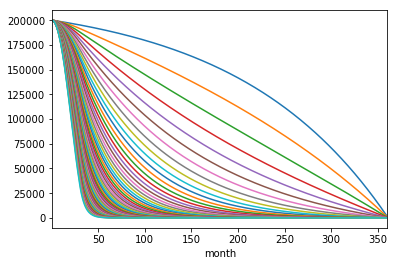

In [18]:
waterfall = {}

figure, axes = plt.subplots()
for i in range(15):
    for j in range(4):
        waterfall[i,j] = cw.create_waterfall(original_balance=200000, 
                        psa_speed=i + (j * 0.25), 
                        pass_thru_cpn=0.075, 
                        wac=0.075,
                        wam=360)
        waterfall[i,j].beginning_balance.plot(ax=axes)
plt.show()

### Evaluating percent of remaining principal balance for different loan maturities and age of loans

In [31]:
results = {}

coupon = 0.08/12.
terms = [180,360]
ages = [24,48,72,96,120,144,168]
    
for term in terms:
    for age in ages:
        results[term,age] = cw.schedule_of_ending_balance_percent_for_period(
        coupon, term, age)

pd.DataFrame(results, index=['% of Rem. Balance at period'])

180                                360            \
                             24   48   72   96   120  144  168  24   48   72    
% of Rem. Balance at period 0.93 0.84 0.73 0.61 0.47 0.30 0.11 0.98 0.96 0.94   

                                                 
                             96   120  144  168  
% of Rem. Balance at period 0.91 0.88 0.84 0.79

### Examples of different choices for expressing prepayments in generating collateral waterfall

In [34]:
original_balance=150000
pass_thru_coupon=0.08
wac=0.08
wam=360

first_wf = cw.create_waterfall(original_balance=original_balance, 
                               pass_thru_cpn=pass_thru_coupon,
                              wac=wac,
                              wam=wam,
                              cpr_description='7')
first_wf['CPR']=first_wf['SMM'].apply(pc.cpr)
first_wf.head()

,beginning_balance,SMM,cash_flow,mortgage_payments,net_interest,prepayments,scheduled_principal,servicing,total_principal,CPR
month,,,,,,,,,,
1,"150,000.00",0.01,"2,004.44","1,100.65","1,000.00",903.79,100.65,0.00,"1,004.44",0.07
2,"148,995.56",0.01,"1,991.74","1,094.01",993.30,897.73,100.71,0.00,998.44,0.07
3,"147,997.12",0.01,"1,979.13","1,087.41",986.65,891.71,100.77,0.00,992.48,0.07
4,"147,004.64",0.01,"1,966.59","1,080.86",980.03,885.73,100.83,0.00,986.56,0.07
5,"146,018.09",0.01,"1,954.12","1,074.34",973.45,879.78,100.89,0.00,980.67,0.07


In [35]:
original_balance=150000
pass_thru_coupon=0.08
wac=0.08
wam=360

second_wf = cw.create_waterfall(original_balance=original_balance, 
                               pass_thru_cpn=pass_thru_coupon,
                              wac=wac,
                              wam=wam,
                              psa_speed=3)
second_wf['CPR']=second_wf['SMM'].apply(pc.cpr)
second_wf.head()

,beginning_balance,SMM,cash_flow,mortgage_payments,net_interest,prepayments,scheduled_principal,servicing,total_principal,CPR
month,,,,,,,,,,
1,"150,000.00",0.00,"1,175.80","1,100.65","1,000.00",75.16,100.65,0.00,175.80,0.01
2,"149,824.20",0.00,"1,250.65","1,100.10",998.83,150.55,101.27,0.00,251.82,0.01
3,"149,572.38",0.00,"1,325.07","1,098.99",997.15,226.08,101.84,0.00,327.92,0.02
4,"149,244.46",0.00,"1,398.94","1,097.33",994.96,301.62,102.36,0.00,403.98,0.02
5,"148,840.48",0.00,"1,472.16","1,095.11",992.27,377.06,102.84,0.00,479.89,0.03


          Yield  spot_rate
Maturity                  
1.00       7.00       7.00
2.00       8.00       8.04
3.00       9.00       9.13
4.00      10.00      10.27


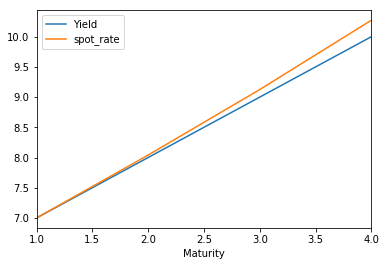

In [73]:
bonds = pd.DataFrame([
    {'Face': 100, 'Maturity': 0.25, 'Coupon': 0, 'Price': 97.50},
    {'Face': 100, 'Maturity': 0.5, 'Coupon': 0, 'Price': 94.90},
    {'Face': 100, 'Maturity': 1.0, 'Coupon': 0, 'Price': 90.00},
    {'Face': 100, 'Maturity': 1.5, 'Coupon': 8, 'Price': 96.00},
    {'Face': 100, 'Maturity': 2.0, 'Coupon': 12, 'Price': 101.60}
])

bonds['coupon_freq'] = 1

bonds = bp.BondPricing(bonds)
spot_curve = bonds.spot_from_par()
print(spot_curve)
spot_curve.plot(y=['Yield','spot_rate'])
plt.show()

### Calculating forward rates

In [122]:
maturity1 = 1
maturity2 = 4

fwd_cont = bp.BondPricing.forward_rate(spot_curve.loc[maturity1,'spot_rate']/100,
                                      maturity1,
                                      spot_curve.loc[maturity2,'spot_rate']/100,
                                      maturity2, continuous=True) * 100
fwd_discrete = bp.BondPricing.forward_rate(spot_curve.loc[maturity1,'spot_rate']/100,
                                      maturity1,
                                      spot_curve.loc[maturity2,'spot_rate']/100,
                                      maturity2, continuous=False) * 100

print('Continuous compounding:\t{0:.2f}%\nDiscrete compounding:\t{1:.2f}%'.format(fwd_cont,fwd_discrete))

Continuous compounding:	11.36%
Discrete compounding:	11.39%


### Interacting with Excel workbook
#### Values driving collateral waterfall should be in cells B1:B6:
B1 = original balance; 
B2 = weighted average maturity; 
B3 = weighted average coupon (gross coupon);
B4 = pass-thru coupon (net coupon);
B5 = PSA speed;
B6 = CPR description (i.e. PSA = '.2 ramp 6 for 30, 6')

In [ ]:
wb = xw.Book('/Users/ab4017/Google Drive/Programming/Python/zeusRMBS/mbs waterfall.xlsm')

In [ ]:
sheet1 = wb.sheets(1)
values = sheet1.range('B1:B6').value

balance = values[0]
WAM = int(values[1])
WAC = values[2]
ptc = values[3]
speed = values[4]
cpr = values[5]

anchor = sheet1.range('A9')

# Plot multiple principal paydowns at different PSA speeds and add figure to spreadsheet

for speed in np.arange(.5, 3.1, .5):
    waterfall = cw.create_waterfall(original_balance=balance,
                                   wam=WAM,
                                   wac=WAC,
                                   pass_thru_cpn=ptc,
                                   psa_speed=speed,
                                   cpr_description=cpr)
    waterfall.rename(columns={'beginning_balance': str(speed)},
                    inplace=True)
    ax = waterfall[str(speed)].plot(legend=True)
    fig = ax.get_figure()

    sheet1.pictures.add(fig, name='Adam',update=True)

anchor.expand().value = ""
anchor.value = waterfall
